# OpenAI - Request for Research 2.0 (https://blog.openai.com/requests-for-research-2/)

## Warmup

   Train an LSTM to solve the XOR problem: that is, given a sequence of bits, determine its parity. The LSTM should consume the sequence, one bit at a time, and then output the correct answer at the sequence’s end. Test the two approaches below:

 *  Generate a dataset of random 100,000 binary strings of length 50. Train the LSTM; what performance do you get?

 *  Generate a dataset of random 100,000 binary strings, where the length of each string is independently and randomly chosen between 1 and 50. Train the LSTM. Does it succeed? What explains the difference?


In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import inspect
import torch.utils.data as data_utils
import pdb
import random
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.nn.utils.rnn as rnn_utils
import pandas as pd
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle

torch.manual_seed(0)  

2.6881325699785736

## Generating Bits String

In [59]:
def generate_binary(length=1, num=1, prob=0.25, is_random=False):
    inputs = []
    targets = []
    for i in range(0, int(round(num))):
        p_ = random.uniform(0, prob) if is_random else prob
        buf = np.random.binomial(n=1, p=p_, size=(length))    
        inputs.append([[(i+1)%2, (i)%2] for i in buf])
        targets.append(np.cumsum(buf) % 2)
    return torch.Tensor(inputs), torch.Tensor(targets).unsqueeze(2)

def collate_generate(sequencelength=50, batchsize=2, is_variable_length=False):
    def pad_collate(batch):
        data = [item[0][0:sequencelength] for item in batch]
        target = [item[1][0:sequencelength] for item in batch]
        length = sequencelength
        
        lengths_vector = [random.randint(1,length) if is_variable_length else length for i in range(0, batchsize)]
        lengths_vector.sort(reverse=True)
        
        data = rnn_utils.pack_padded_sequence(torch.stack(data), lengths_vector, batch_first=True)
        target = rnn_utils.pack_padded_sequence(torch.stack(target), lengths_vector, batch_first=True)
        return [data, target]
    return pad_collate

def flatten(S):
    if S == []:
        # terminal condition
        return S
    elif isinstance(S[0], list):
        # first element is list
        return flatten(S[0]) + flatten(S[1:])
    else:
        # first element is not a list
        return S[:1] + flatten(S[1:])
    
def tensors2array(data):
    return [i[:, 1].sum() for i in data]

def pad_and_average(lists):
    # padding
    N = max([len(x) for x in lists])
    new_lists = [x + [0] * (N - len(x)) for x in lists]
    return np.mean(new_lists ,axis=0)

# Single Layer LSTM Model

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, feature_size, hidden_size):
        super(LSTMModel, self).__init__()
        self.feature_size = feature_size
        self.hidden_size = hidden_size
        
        self.rnn = nn.LSTM(
            input_size=feature_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True)
        self.h2o = nn.Linear(hidden_size, 1)
        self.sig = nn.Sigmoid()

    def unpacked(self, hidden):
        if isinstance(hidden, torch.nn.utils.rnn.PackedSequence):
            hidden, lengths_vector = rnn_utils.pad_packed_sequence(hidden, batch_first=True)
        return hidden
        
    def forward(self, inputs):
        h, h_and_c = self.rnn(inputs)
        h = self.unpacked(h)
        outputs = self.h2o(h)
        return outputs, self.sig(outputs), h_and_c

    def initRandomHidden(self, batch_size=1):
        h = torch.zeros(1, batch_size, self.hidden_size)
        c = torch.zeros(1, batch_size, self.hidden_size)
        return [h, c]

# Training with fixed length 50
 *  Generate a dataset of random 100,000 binary strings of length 2, 10, 30, 50. Test on fixed 50 length dataset.

* batch size 20
* Adam optimizer with learning rate 0.01
* Cross Entropy Loss
* The model doesn't need to learn long dependency but to learn the gates that can read and write parity information to/from state. Each model achieves 100 % within 3 epochs
* The longer the sequence, the longer time it took to converge to optima. Main explanation is the longer the sequence, the worse gradient morphing (vanishes/explode), makes the network hard to learn toe correct signal. Also the gradient vanishing caused the gradient to be dominated by short term input. Besides shorter sequence has expontially smaller sample space makes problem mucher easier.

##### Below is some experiments result. Note that the legend (N, false) means training with sequences with fixed length N. (N, false) means training with  sequences with variable lengths [1, N]

#### Cross Entropy Loss on length 50 testset

![title](./xor1.png)

#### Cross Entropy Loss on Training set (length N)


![title](./xor2.png)

#### Cross Entropy Loss on testset (length 50)

![title](./xor3.png)

#### Cross Entropy Loss on Training set (length N)

![title](./xor4.png)

# Training with variable length in [1,50]


* batch size 20
* Adam optimizer with learning rate 0.01
* Cross Entropy Loss
* Test model trained with fix length and variable length
 
### Compared to training with fixed size strings, network is easier to learn with variable length strings. My explaination is the random strings form a curriculum which consists of easy(short) and hard(long) tasks. Short task is easier for gradient learning and expontially easiery than 50-length xor problem.

#### Cross Entropy Loss of training

![title](./xor6.png)

#### Cross Entropy Loss on Testset (training with fixed and variable length, testing on length 50)

![title](./xor5.png)

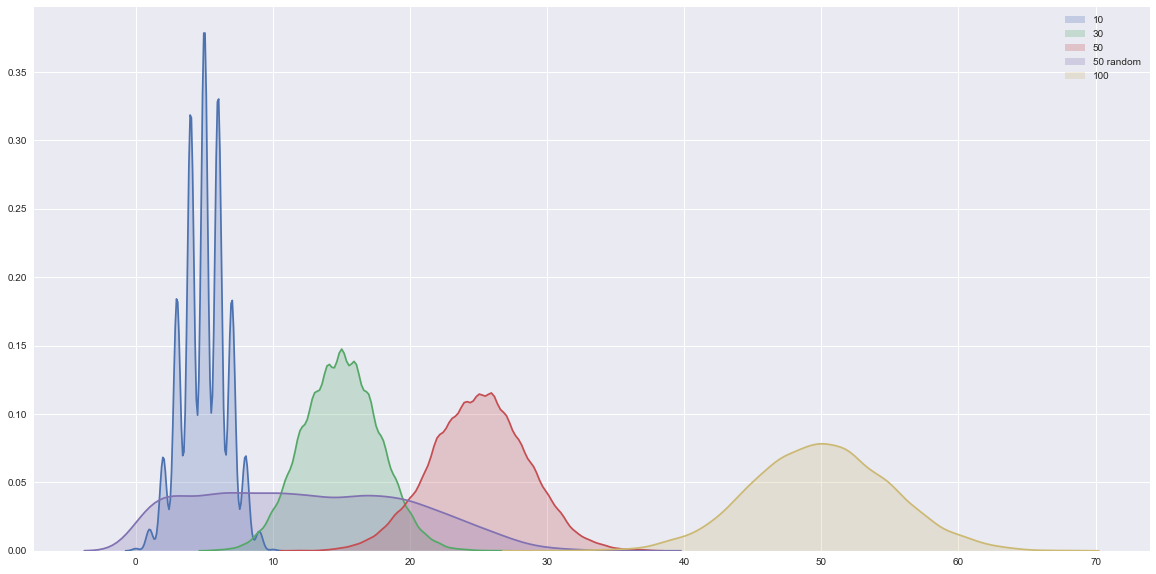

In [242]:
legends = []
fig, ax = plt.subplots(figsize=(20, 10))

bins = 80
def plot_it(data):
    #sns.distplot(data, bins=bins, ax=ax);
    sns.kdeplot(data, shade=True)

#sns.distplot([i[-1] for i in targets], kde=False, bins=30, ax=ax);
inputs, _ = generate_binary(length=10, num=10000, prob=0.5, is_random=False)
plot_it(tensors2array(inputs))
legends.append("10")

inputs, _ = generate_binary(length=30, num=10000, prob=0.5, is_random=False)
plot_it(tensors2array(inputs))
legends.append("30")

inputs, _ = generate_binary(length=50, num=10000, prob=0.5, is_random=False)
plot_it(tensors2array(inputs))
legends.append("50")


inputs, _ = generate_binary(length=50, num=10000, prob=0.5, is_random=False)
qi = []
for i in inputs:
    qi.append(i[:random.randint(1,49), 1].sum())
plot_it(qi)
legends.append("50 random")

inputs, _ = generate_binary(length=100, num=10000, prob=0.5, is_random=False)
plot_it(tensors2array(inputs))
legends.append("100")
    
    
plt.legend(legends)


In [239]:
''' Training code '''

print_every = 300
save_loss_every = 2
repeat_configuration = 5

epochs = 2
num_observation = 10000
num_test_observation = 100

hidden_size = 2
batch_size = 20
max_length = 100
test_max_length = 200

criterion = nn.BCEWithLogitsLoss(reduction='elementwise_mean')

def evaluate(model, inputs, targets, length, is_variable_length=True):
    accuracy = 0
    num_samples = inputs.shape[0]
    batch_size = num_samples
    
    dataset = torch.utils.data.TensorDataset(inputs, targets)
    
    loss = 0
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
        drop_last=True,
        collate_fn=collate_generate(sequencelength=length, batchsize=batch_size, is_variable_length=is_variable_length),
        pin_memory=True)

    for batch_idx, data in enumerate(dataloader, 1):

        '''
        input[1] is tensor([20, 13,  9,  7,  4]) which represents
        say batch size is 4, 
        input[1] should be [4, 2, 2, 1]: first element from all 4 sequences, second from 2 sequences... 
        last element only from first sequence.

        1 1 1 1 
        1 1 1 
        1 
        1 
        '''
        input, target = data  
        
        output_tensor, predict_tensor, _ = model(input)
        
        # unpack
        target_tensor, lengths_vector = rnn_utils.pad_packed_sequence(target, batch_first=True)
        
        # pack
        output = rnn_utils.pack_padded_sequence(output_tensor, lengths_vector, batch_first=True)
        
        loss += criterion(output.data, target.data)
        
        # we only care the final output of each string which is at index i-1 for i in lengths_vector
        for idx_in_batch, idx_in_sequence in enumerate(lengths_vector.tolist(), 0):
            accuracy += ((predict_tensor[idx_in_batch, idx_in_sequence-1] > 0.5).numpy() ==  target_tensor[idx_in_batch, idx_in_sequence-1].numpy())
    return accuracy[0] / num_samples


def evaluate_with_generated_data(model, test_length=50, num_samples=100, is_variable_length=False, prob=0.2):
    inputs, targets = generate_binary(length=test_length, num=num_samples, prob=prob)
    return evaluate(model, inputs, targets, test_length, is_variable_length=is_variable_length)


'''
Training
'''
lr = 0.01
model_list = []


''' training configuration: (Length, IsRandomLength, ProbabilityOf1, IsRandomProb) '''
curriculum = [(50, False, 0.5, False), (50, True, 0.5, False)]

test_10_losses_dict = {}
test_30_losses_dict = {}
test_50_losses_dict = {}
losses_dict = {}


'''testing data'''
test_inputs, test_targets = generate_binary(length=test_max_length, num=num_test_observation, prob=0.5, is_random=False)


''' testing loss data '''
test_10_loss_inputs, test_10_loss_targets = generate_binary(length=10, num=100, prob=0.5, is_random=False)
test_30_loss_inputs, test_30_loss_targets = generate_binary(length=30, num=100, prob=0.5, is_random=False)
test_50_loss_inputs, test_50_loss_targets = generate_binary(length=50, num=100, prob=0.5, is_random=False)








def test_loss(model, inputs, targets):
    outputs, _, _ = model(inputs)
    return criterion(outputs, targets).item()


for idx, curriculum_set in enumerate(curriculum): 
    length, is_random_length, probability, is_random_prob = curriculum_set
    
    ''' training data '''
    inputs, targets = generate_binary(length=length, num=num_observation, prob=probability, is_random=is_random_prob)
    dataset = torch.utils.data.TensorDataset(inputs, targets)
    
    
    ''' training dataloader '''
    dataloader = torch.utils.data.DataLoader(
                    dataset,
                    batch_size=batch_size,
                    shuffle=True,
                    num_workers=1,
                    drop_last=True,
                    collate_fn=collate_generate(sequencelength=length, batchsize=batch_size,  is_variable_length=is_random_length),
                    pin_memory=True)

    
    
    for repeat_configuration_idx in range(1, repeat_configuration+1): 
        
        print ("{} run, curriculum {}, learning rate {}, batch size {}, training length {}, probability {}"
               .format(repeat_configuration_idx, curriculum_set, lr, batch_size, length, probability))
  
        
        ## initialize model
        model = LSTMModel(2, hidden_size)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # tracking stats
        test_10_losses = []
        test_30_losses = []
        test_50_losses = []
        losses = []
        
        
        try:
            for i in range(1, epochs+1):    
                running_loss = 0
                for batch_idx, data in enumerate(dataloader, 1):
                    optimizer.zero_grad()

                    input, target = data 
                    output, _, _ = model(input)

                    # unpack targets PackedSequence to get variable length vector
                    _, lengths_vector = rnn_utils.pad_packed_sequence(target, batch_first=True)
                    
                    # use pack_padded_sequence function to flatten output according to variable length vector
                    output = rnn_utils.pack_padded_sequence(output, lengths_vector, batch_first=True)

                    #loss = criterion(output.data[-1].unsqueeze(0), target.data[-1].unsqueeze(0))
                    loss = criterion(output.data, target.data)

                    running_loss += loss

                    loss.backward()

                    optimizer.step()


                    if batch_idx % save_loss_every == 0:
                        test_10_losses.append(test_loss(model, test_10_loss_inputs, test_10_loss_targets))
                        test_30_losses.append(test_loss(model, test_30_loss_inputs, test_30_loss_targets))
                        test_50_losses.append(test_loss(model, test_50_loss_inputs, test_50_loss_targets))
                        losses.append(loss.item())

                    if batch_idx % print_every == 0:
                        print ("epoch {}, batch {}, loss {}".format(i, batch_idx, running_loss / print_every))
                        if running_loss / print_every < 1e-4:
                            raise StopIteration
                        running_loss = 0

                        
                print ("Accuracy: {} %".format(evaluate_with_generated_data(model, test_length=length, num_samples=100, is_variable_length=False)
    * 100))
            
        except StopIteration:
            print ("{} curriculum early exit.".format(curriculum_set))

        print ('Test Set Accuracy: {} % \n'.format(evaluate(model, test_inputs, test_targets, length=test_max_length, is_variable_length=False) * 100), '#' * 100)

        ''' collect each repeat model run for curriculum summary'''
        if curriculum_set not in losses_dict:
            losses_dict[curriculum_set] = []
        losses_dict[curriculum_set].append(losses)

        
        if curriculum_set not in test_50_losses_dict:
            test_10_losses_dict[curriculum_set] = []
            test_30_losses_dict[curriculum_set] = []
            test_50_losses_dict[curriculum_set] = []
        test_10_losses_dict[curriculum_set].append(test_10_losses)
        test_30_losses_dict[curriculum_set].append(test_30_losses)
        test_50_losses_dict[curriculum_set].append(test_50_losses)

    
    ''' curriculum loss summary '''
    losses_dict[curriculum_set] = pad_and_average(losses_dict[curriculum_set])
    test_10_losses_dict[curriculum_set] = pad_and_average(test_10_losses_dict[curriculum_set])
    test_30_losses_dict[curriculum_set] = pad_and_average(test_30_losses_dict[curriculum_set])
    test_50_losses_dict[curriculum_set] = pad_and_average(test_50_losses_dict[curriculum_set])

    
    ''' Save Losses: save to different  '''
    with open("{}_model_losses".format(str(curriculum_set)), 'wb') as file:
        buffer = {}
        buffer['model'] = model
        buffer['losses'] = losses_dict[curriculum_set]
        pickle.dump(buffer, file, pickle.HIGHEST_PROTOCOL)
    print ("{}_model_losses saved".format(str(curriculum_set)))
    model_list.append(model)

1 run, curriculum (50, False, 0.5, False), learning rate 0.01, batch size 20, training length 50, probability 0.5
epoch 1, batch 300, loss 0.6947634816169739
Accuracy: 53.0 %
epoch 2, batch 300, loss 0.6920410990715027
Accuracy: 75.0 %
Test Set Accuracy: 99.0 % 
 ####################################################################################################
2 run, curriculum (50, False, 0.5, False), learning rate 0.01, batch size 20, training length 50, probability 0.5
epoch 1, batch 300, loss 0.640327513217926
Accuracy: 100.0 %
epoch 2, batch 300, loss 0.02915319986641407
Accuracy: 100.0 %
Test Set Accuracy: 100.0 % 
 ####################################################################################################
3 run, curriculum (50, False, 0.5, False), learning rate 0.01, batch size 20, training length 50, probability 0.5
epoch 1, batch 300, loss 0.6915804147720337
Accuracy: 100.0 %
epoch 2, batch 300, loss 0.04942801222205162
Accuracy: 100.0 %
Test Set Accuracy: 100.0 % 


Training the same network on 100000 bits string with length with 2, 5, 12, 25, 50, 100 respectively and test it on 10000 bits string with variable lengths between 1 and 50. 
Two observations.
1. Shorter the string, easier the training. Probably because to get the correct parity, network needs to memorize each bit in the string. Longer dependency is harder to learn due to gradient explosion through bptt.
2. Loss stays still then sudden drops to zero.


In [12]:
# test long dependency
# 10000...000001 

accuracy = 0
test_samples = 300

for j in range(0, test_samples):
    tt = [[0., 1.]]
    for i in range(0, j):
        tt.append([1., 0.])
    tt.append([0., 1.])
    ans = np.sum([e[1] for e in tt]) % 2
    
    out, predict, hiddens = model(torch.Tensor(tt).unsqueeze(0))
    
    #print (predict[0][-1])
    accuracy += ((predict[0][-1] > 0.5) == ans)[0]
    #print ((predict[0][-1] > 0.5) == ans)

print (accuracy.numpy() / test_samples * 100, " %")

14.666666666666666  %


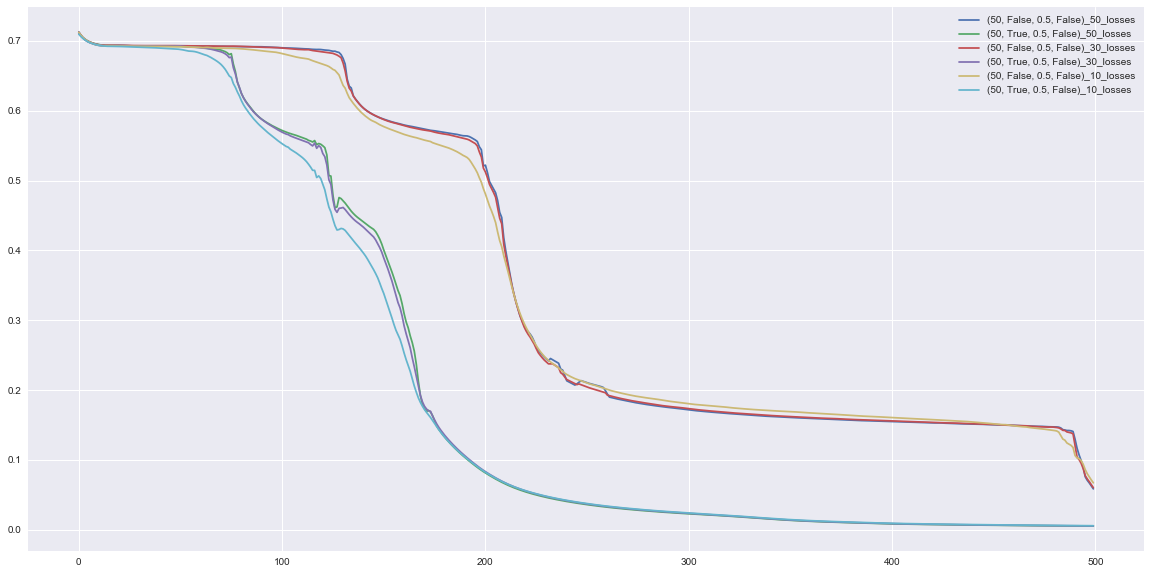

In [240]:
# testset loss
import seaborn as sns
sns.set(color_codes=True)
fig, ax = plt.subplots(figsize=(20, 10))
legends = []

for k,v in test_50_losses_dict.items():
    plt.plot(v)
    legends.append(str(k) + "_50_losses")
    
for k,v in test_30_losses_dict.items():
    plt.plot(v)
    legends.append(str(k) + "_30_losses")

for k,v in test_10_losses_dict.items():
    plt.plot(v)
    legends.append(str(k) + "_10_losses")
    
    
    
plt.legend(legends)

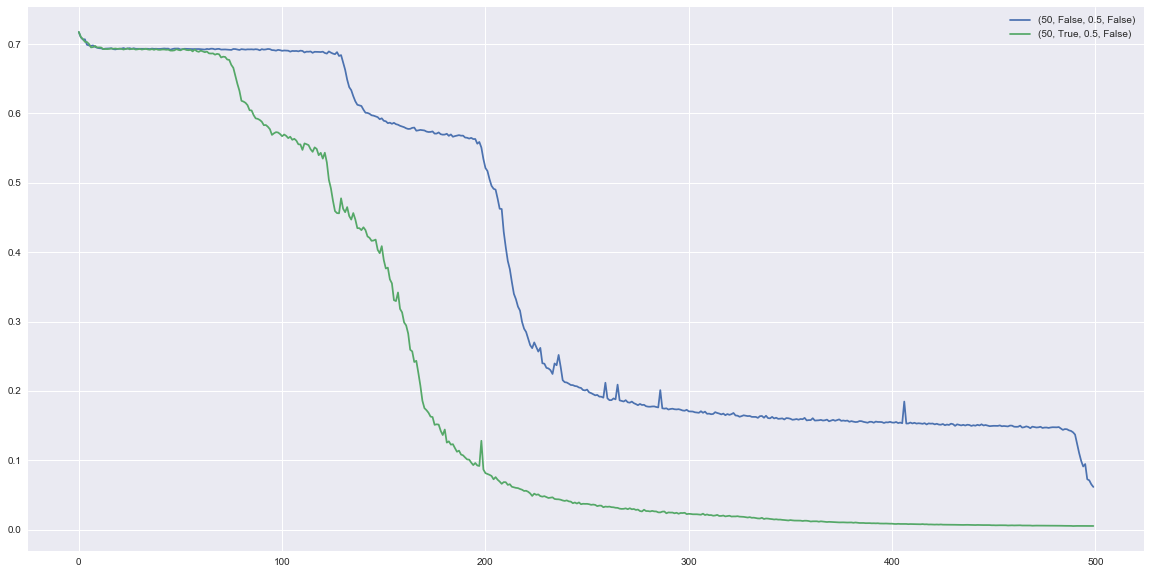

In [241]:
# training loss
import seaborn as sns
sns.set(color_codes=True)
fig, ax = plt.subplots(figsize=(20, 10))
legends = []
for k,v in losses_dict.items():
    plt.plot(v)
    legends.append(k)
plt.legend(legends)

In [ ]:
''' Vanishing gradients in a 50 length sequence '''

max_length = 50
gradient_vector = []

model = LSTMModel(2, 2)

# for short to long
inputs, targets = generate_binary(length=max_length, num=10000)

for length in range(1, max_length):
    model.zero_grad()    
    
    input = inputs[:, (max_length - length):,  :]
    target = targets[:, (max_length - length):,  :]
    outputs, _ = model(input)
    
    loss = criterion(outputs, target).backward()
    gradient_vector.append(model.rnn.weight_ih_l0.grad.abs().sum())
    
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot([abs((curr - prev) / prev) for prev, curr in zip(gradient_vector, gradient_vector[1:])])

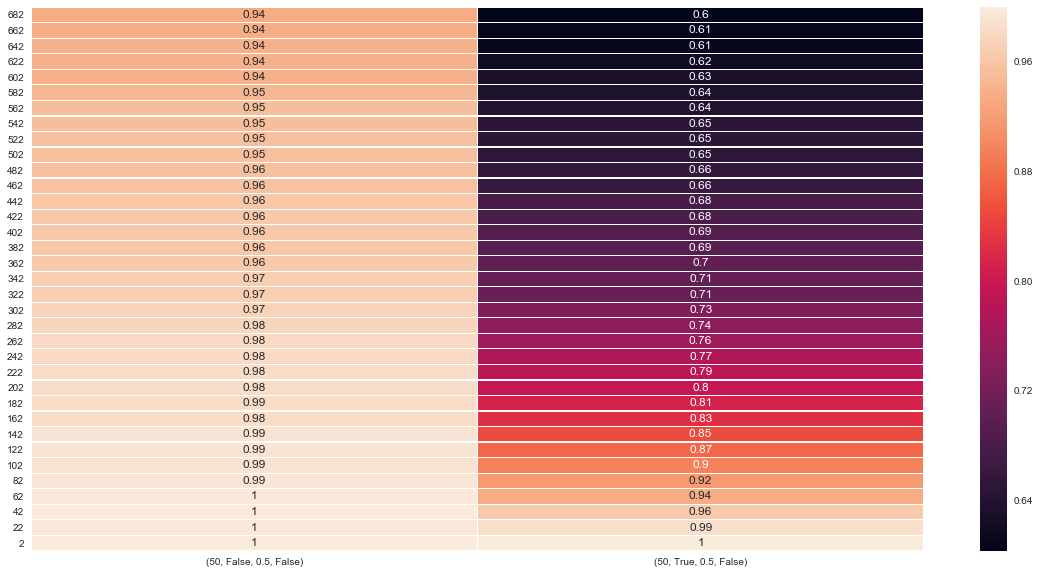

In [222]:
'''  
Visualize heatmap to compare testset and trainset performance 
'''

import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()

max_length = 700
inputs, targets = generate_binary(length=max_length, num=1000, prob=0.25)

data = pd.DataFrame(columns = curriculum)
for i in range(2, max_length, 20):
    buff = []
    for idx, model in enumerate(model_list):
        print 
        buff.append(evaluate(model, inputs, targets, length=i, is_variable_length=False))
    data.loc[i] = buff

data = data.iloc[::-1]


fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.heatmap(data, annot=True, linewidths=.2, ax=ax) # square=True, 
